In [42]:
import torch
import pandas as pd
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset, Dataset
from sklearn.model_selection import train_test_split

In [43]:
model_name = "indobenchmark/indobert-base-p1"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

/mnt/e/Environment/pytorch/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1617: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be deprecated in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p1 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [44]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(50000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [45]:
data = pd.read_csv("data/preprocessed_data.csv")
data = data.dropna(subset=["Tweet"])
data["Tweet"] = data["Tweet"].astype(str)


In [46]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)
train_dataset = Dataset.from_pandas(train_data)
test_dataset = Dataset.from_pandas(test_data)

In [47]:
def preprocess_function(examples):
    return tokenizer(examples['Tweet'], padding='max_length', truncation=True, max_length=256)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/10496 [00:00<?, ? examples/s]

Map: 100%|██████████| 2625/2625 [00:00<00:00, 10285.77 examples/s]


In [48]:
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'labels'])

In [61]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    logits, labels = pred
    predictions = logits.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average='weighted')
    
    return {
        'accuracy': accuracy,
        'f1': f1
    }

In [55]:
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    fp16=True,
    load_best_model_at_end=True,
    report_to="none",
)


/mnt/e/Environment/pytorch/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [56]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics
)

trainer.train()

trainer.save_model("./indobert-finetuned")

/mnt/e/Environment/pytorch/lib/python3.10/site-packages/accelerate/accelerator.py:494: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(**kwargs)


Epoch,Training Loss,Validation Loss
1,0.287700,0.378890
2,0.311900,0.369472
3,0.211500,0.514099


## Evaluasi

In [65]:
predictions = trainer.predict(test_dataset)

In [67]:
import numpy as np
preds = np.argmax(predictions.predictions, axis=1)
labels = predictions.label_ids

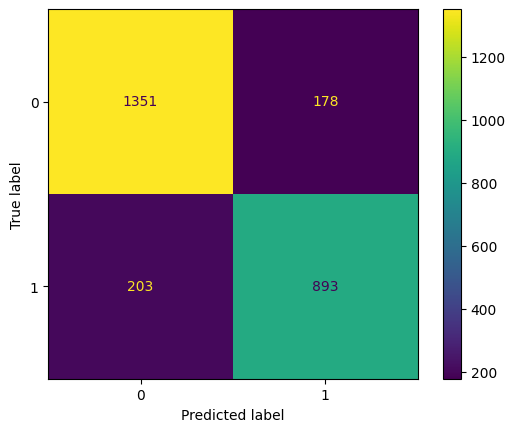

In [68]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(labels, preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

plt.show()

In [76]:
from sklearn.metrics import classification_report

report = classification_report(labels, preds, output_dict=True)

{'0': {'precision': 0.8693693693693694, 'recall': 0.8835840418574231, 'f1-score': 0.876419072332144, 'support': 1529.0}, '1': {'precision': 0.8338001867413632, 'recall': 0.8147810218978102, 'f1-score': 0.8241808952468851, 'support': 1096.0}, 'accuracy': 0.8548571428571429, 'macro avg': {'precision': 0.8515847780553663, 'recall': 0.8491825318776167, 'f1-score': 0.8502999837895145, 'support': 2625.0}, 'weighted avg': {'precision': 0.8545183887368761, 'recall': 0.8548571428571429, 'f1-score': 0.8546083896329274, 'support': 2625.0}}


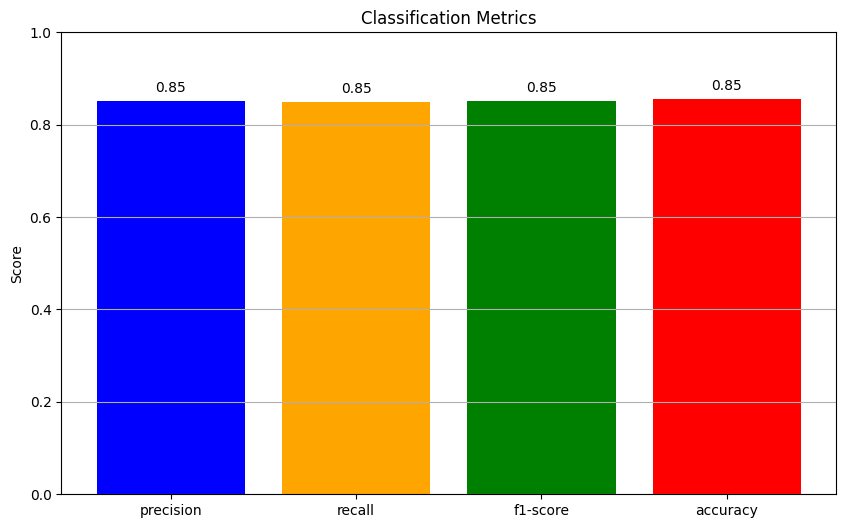

In [77]:
metrics = {
    'precision': report['macro avg']['precision'],
    'recall': report['macro avg']['recall'],
    'f1-score': report['macro avg']['f1-score'],
    'accuracy': report['accuracy']
}

plt.figure(figsize=(10, 6))
plt.bar(metrics.keys(), metrics.values(), color=['blue', 'orange', 'green', 'red'])
plt.title('Classification Metrics')
plt.ylabel('Score')
plt.ylim(0, 1) 
plt.grid(axis='y')


for i, value in enumerate(metrics.values()):
    plt.text(i, value + 0.02, f"{value:.2f}", ha='center')

plt.show()

In [79]:
tokenizer.save_pretrained("./indobert-finetuned")

('./indobert-finetuned/tokenizer_config.json',
 './indobert-finetuned/special_tokens_map.json',
 './indobert-finetuned/vocab.txt',
 './indobert-finetuned/added_tokens.json',
 './indobert-finetuned/tokenizer.json')